学习{mlr3verse}高级调优方法。

# 错误处理与内存管理

In [2]:
library(mlr3verse)
library(tidyverse)

Loading required package: mlr3

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.2     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
tsk_pen <- tsk("penguins")
# 移除缺失值行
tsk_pen$filter(tsk_pen$row_ids[complete.cases(tsk_pen$data())])
# 创建自定义重采样，测试集包含新的因子水平
rsmp_custom <- rsmp("custom")
rsmp_custom$instantiate(
  tsk_pen,
  list(tsk_pen$row_ids[tsk_pen$data()$island != "Torgersen"]),
  list(tsk_pen$row_ids[tsk_pen$data()$island == "Torgersen"])
)
msr_ce <- msr("classif.ce")
tnr_random <- tnr("random_search")
learner <- lrn("classif.lda", method = "t", nu = to_tune(3, 10))

tune(
  tnr_random,
  tsk_pen,
  learner,
  rsmp_custom,
  msr_ce,
  10
)

# Error in lda.default(x, grouping, ...): variable 6 appears to be constant within groups
# Traceback:

INFO  [15:24:17.863] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=10, k=0]'
INFO  [15:24:17.880] [bbotk] Evaluating 1 configuration(s)
INFO  [15:24:17.887] [mlr3] Running benchmark with 1 resampling iterations
INFO  [15:24:17.914] [mlr3] Applying learner 'classif.lda' on task 'penguins' (iter 1/1)


ERROR: Error in lda.default(x, grouping, ...): variable 6 appears to be constant within groups


In [4]:
learner$encapsulate(method = "evaluate", fallback = lrn("classif.featureless"))

In [8]:
learner$timeout <- c(train = 30, predict = 30)

In [ ]:
instance <- tune(tnr_random, tsk_pen, learner, rsmp_custom, msr_ce, 10)

INFO  [15:51:47.630] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=10, k=0]'
INFO  [15:51:47.642] [bbotk] Evaluating 1 configuration(s)
INFO  [15:51:47.647] [mlr3] Running benchmark with 1 resampling iterations
INFO  [15:51:47.651] [mlr3] Applying learner 'classif.lda' on task 'penguins' (iter 1/1)
ERROR [15:51:47.658] [mlr3] train: variable 6 appears to be constant within groups
INFO  [15:51:47.662] [mlr3] Learner 'classif.lda' on task 'penguins' failed to train a model {learner: <LearnerClassifLDA/LearnerClassif/Learner/R6>, messages: `variable 6 appears to be constant within groups`}
INFO  [15:51:47.664] [mlr3] Calling train method of fallback 'classif.featureless' on task 'penguins' with 286 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:51:47.677] [mlr3] Finished benchmark
INFO  [15:51:47.713] [bbotk] Result of batch 1:
INFO  [15:51:47.716] [bbotk]  nu classif.ce warnings err

In [ ]:
as.data.table(instance$archive)[1:3, .(df, classif.ce, errors)] %>% print()

# df classif.ce errors
#           <list>      <num>  <int>
# 1: <function[1]>          1      1
# 2: <function[1]>          1      1
# 3: <function[1]>          1      1

              df classif.ce errors
          <list>      <num>  <int>
1: <function[1]>          1      1
2: <function[1]>          1      1
3: <function[1]>          1      1


In [ ]:
# 读取第一次抽样错误
instance$archive$resample_result(1)$errors %>% print()

# iteration                                             msg
#        <int>                                          <char>
# 1:         1 variable 6 appears to be constant within groups

   iteration                                             msg
       <int>                                          <char>
1:         1 variable 6 appears to be constant within groups


In [ ]:
instance$result %>% print()

# nu learner_param_vals  x_domain classif.ce
#    <int>             <list>    <list>      <num>
# 1:    10          <list[2]> <list[1]>          1

      nu learner_param_vals  x_domain classif.ce
   <int>             <list>    <list>      <num>
1:    10          <list[2]> <list[1]>          1


In [20]:
as.data.table(instance$archive)

nu,classif.ce,runtime_learners,timestamp,warnings,errors,x_domain,batch_nr,resample_result
<int>,<dbl>,<dbl>,<dttm>,<int>,<int>,<list>,<int>,<list>
10,1,NA,2025-05-21 15:51:47,0,1,10,1,<environment: 0x11aef75b8>
9,1,NA,2025-05-21 15:51:47,0,1,9,2,<environment: 0x11af18c08>
9,1,NA,2025-05-21 15:51:47,0,1,9,3,<environment: 0x11af2f270>
3,1,NA,2025-05-21 15:51:47,0,1,3,4,<environment: 0x11af4eb60>
6,1,NA,2025-05-21 15:51:47,0,1,6,5,<environment: 0x11af695f0>
10,1,NA,2025-05-21 15:51:47,0,1,10,6,<environment: 0x11af8ac40>
3,1,NA,2025-05-21 15:51:47,0,1,3,7,<environment: 0x11afa9158>
6,1,NA,2025-05-21 15:51:47,0,1,6,8,<environment: 0x11afceaf0>
9,1,NA,2025-05-21 15:51:47,0,1,9,9,<environment: 0x11aff6c08>


# 多目标调优

In [22]:
learner <- lrn(
  "classif.rpart",
  cp = to_tune(1e-04, 1e-1),
  minsplit = to_tune(2, 64),
  maxdepth = to_tune(1, 30)
)

measures <- msrs(c("classif.ce", "selected_features"))

In [ ]:
instance <- ti(
  task = tsk("sonar"),
  learner = learner,
  resampling = rsmp("cv", folds = 3),
  measures = measures,
  terminator = trm("evals", n_evals = 30),
  store_models = TRUE
)
instance

# <TuningInstanceBatchMultiCrit>
# * State:  Not optimized
# * Objective: <ObjectiveTuningBatch:classif.rpart_on_sonar>
# * Search Space:
#          id    class lower upper nlevels
#      <char>   <char> <num> <num>   <num>
# 1:       cp ParamDbl 1e-04   0.1     Inf
# 2: maxdepth ParamInt 1e+00  30.0      30
# 3: minsplit ParamInt 2e+00  64.0      63
# * Terminator: <TerminatorEvals>

<TuningInstanceBatchMultiCrit>
* State:  Not optimized
* Objective: <ObjectiveTuningBatch:classif.rpart_on_sonar>
* Search Space:
         id    class lower upper nlevels
     <char>   <char> <num> <num>   <num>
1:       cp ParamDbl 1e-04   0.1     Inf
2: maxdepth ParamInt 1e+00  30.0      30
3: minsplit ParamInt 2e+00  64.0      63
* Terminator: <TerminatorEvals>

In [24]:
tuner <- tnr("random_search")
tuner$optimize(instance)

INFO  [16:50:37.565] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=30, k=0]'
INFO  [16:50:37.593] [bbotk] Evaluating 1 configuration(s)
INFO  [16:50:37.601] [mlr3] Running benchmark with 3 resampling iterations
INFO  [16:50:37.609] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/3)
INFO  [16:50:37.659] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/3)
INFO  [16:50:37.672] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/3)
INFO  [16:50:37.685] [mlr3] Finished benchmark
INFO  [16:50:37.712] [bbotk] Result of batch 1:
INFO  [16:50:37.714] [bbotk]          cp maxdepth minsplit classif.ce selected_features warnings errors
INFO  [16:50:37.714] [bbotk]  0.08587453       17        5  0.3267081                 2        0      0
INFO  [16:50:37.714] [bbotk]  runtime_learners                                uhash
INFO  [16:50:37.714] [bbotk]             0.031 6c4c5c2d-c615-43b1-9796-8

cp,maxdepth,minsplit,learner_param_vals,x_domain,classif.ce,selected_features
<dbl>,<int>,<int>,<list>,<list>,<dbl>,<dbl>
0.038635296,8,37,"0.0000000, 0.0386353, 8.0000000, 37.0000000","0.0386353, 8.0000000, 37.0000000",0.2930297,2.333333
0.082525794,29,55,"0.00000000, 0.08252579, 29.00000000, 55.00000000","0.08252579, 29.00000000, 55.00000000",0.2933057,1.000000
0.006479818,6,21,"0.000000000, 0.006479818, 6.000000000, 21.000000000","0.006479818, 6.000000000, 21.000000000",0.2642512,5.333333
0.045698477,8,14,"0.00000000, 0.04569848, 8.00000000, 14.00000000","0.04569848, 8.00000000, 14.00000000",0.2641822,5.666667
0.020751516,1,35,"0.00000000, 0.02075152, 1.00000000, 35.00000000","0.02075152, 1.00000000, 35.00000000",0.2933057,1.000000
0.010971691,9,38,"0.00000000, 0.01097169, 9.00000000, 38.00000000","0.01097169, 9.00000000, 38.00000000",0.2785369,3.000000
0.099240409,26,45,"0.00000000, 0.09924041, 26.00000000, 45.00000000","0.09924041, 26.00000000, 45.00000000",0.2933057,1.000000
0.043729808,10,25,"0.00000000, 0.04372981, 10.00000000, 25.00000000","0.04372981, 10.00000000, 25.00000000",0.2691511,3.333333


In [ ]:
instance$archive$best()[
  , .(cp, minsplit, maxdepth, classif.ce, selected_features)
] %>% print()

# cp minsplit maxdepth classif.ce selected_features
#          <num>    <int>    <int>      <num>             <num>
# 1: 0.038635296       37        8  0.2930297          2.333333
# 2: 0.082525794       55       29  0.2933057          1.000000
# 3: 0.006479818       21        6  0.2642512          5.333333
# 4: 0.045698477       14        8  0.2641822          5.666667
# 5: 0.020751516       35        1  0.2933057          1.000000
# 6: 0.010971691       38        9  0.2785369          3.000000
# 7: 0.099240409       45       26  0.2933057          1.000000
# 8: 0.043729808       25       10  0.2691511          3.333333

            cp minsplit maxdepth classif.ce selected_features
         <num>    <int>    <int>      <num>             <num>
1: 0.038635296       37        8  0.2930297          2.333333
2: 0.082525794       55       29  0.2933057          1.000000
3: 0.006479818       21        6  0.2642512          5.333333
4: 0.045698477       14        8  0.2641822          5.666667
5: 0.020751516       35        1  0.2933057          1.000000
6: 0.010971691       38        9  0.2785369          3.000000
7: 0.099240409       45       26  0.2933057          1.000000
8: 0.043729808       25       10  0.2691511          3.333333


In [ ]:
instance$result_learner_param_vals %>% print()

# [[1]]
# [[1]]$xval
# [1] 0

# [[1]]$cp
# [1] 0.0386353

# [[1]]$maxdepth
# [1] 8

# [[1]]$minsplit
# [1] 37


# [[2]]
# [[2]]$xval
# [1] 0

# [[2]]$cp
# [1] 0.08252579

# [[2]]$maxdepth
# [1] 29

# [[2]]$minsplit
# [1] 55


# [[3]]
# [[3]]$xval
# [1] 0

# [[3]]$cp
# [1] 0.006479818

# [[3]]$maxdepth
# [1] 6

# [[3]]$minsplit
# [1] 21


# [[4]]
# [[4]]$xval
# [1] 0

# [[4]]$cp
# [1] 0.04569848

# [[4]]$maxdepth
# [1] 8

# [[4]]$minsplit
# [1] 14


# [[5]]
# [[5]]$xval
# [1] 0

# [[5]]$cp
# [1] 0.02075152

# [[5]]$maxdepth
# [1] 1

# [[5]]$minsplit
# [1] 35


# [[6]]
# [[6]]$xval
# [1] 0

# [[6]]$cp
# [1] 0.01097169

# [[6]]$maxdepth
# [1] 9

# [[6]]$minsplit
# [1] 38


# [[7]]
# [[7]]$xval
# [1] 0

# [[7]]$cp
# [1] 0.09924041

# [[7]]$maxdepth
# [1] 26

# [[7]]$minsplit
# [1] 45


# [[8]]
# [[8]]$xval
# [1] 0

# [[8]]$cp
# [1] 0.04372981

# [[8]]$maxdepth
# [1] 10

# [[8]]$minsplit
# [1] 25

[[1]]
[[1]]$xval
[1] 0

[[1]]$cp
[1] 0.0386353

[[1]]$maxdepth
[1] 8

[[1]]$minsplit
[1] 37


[[2]]
[[2]]$xval
[1] 0

[[2]]$cp
[1] 0.08252579

[[2]]$maxdepth
[1] 29

[[2]]$minsplit
[1] 55


[[3]]
[[3]]$xval
[1] 0

[[3]]$cp
[1] 0.006479818

[[3]]$maxdepth
[1] 6

[[3]]$minsplit
[1] 21


[[4]]
[[4]]$xval
[1] 0

[[4]]$cp
[1] 0.04569848

[[4]]$maxdepth
[1] 8

[[4]]$minsplit
[1] 14


[[5]]
[[5]]$xval
[1] 0

[[5]]$cp
[1] 0.02075152

[[5]]$maxdepth
[1] 1

[[5]]$minsplit
[1] 35


[[6]]
[[6]]$xval
[1] 0

[[6]]$cp
[1] 0.01097169

[[6]]$maxdepth
[1] 9

[[6]]$minsplit
[1] 38


[[7]]
[[7]]$xval
[1] 0

[[7]]$cp
[1] 0.09924041

[[7]]$maxdepth
[1] 26

[[7]]$minsplit
[1] 45


[[8]]
[[8]]$xval
[1] 0

[[8]]$cp
[1] 0.04372981

[[8]]$maxdepth
[1] 10

[[8]]$minsplit
[1] 25




In [35]:
learner <- lrn("classif.rpart")
learner$param_set$values <- instance$result_learner_param_vals[[2]]

In [38]:
as.data.table(instance$archive) %>% colnames()

[1] "cp"                "maxdepth"          "minsplit"         
 [4] "classif.ce"        "selected_features" "runtime_learners" 
 [7] "timestamp"         "warnings"          "errors"           
[10] "x_domain"          "batch_nr"          "resample_result"

In [47]:
as.data.table(instance$archive) %>% dim()

[1] 30 12

In [67]:
df_best <- instance$archive$best()[
  , .(classif.ce, selected_features)
] %>%
  rename(
    classif.ce_best = classif.ce,
    selected_features_best = selected_features
  )

df_all <- as.data.table(instance$archive)[
  , .(classif.ce, selected_features)
]

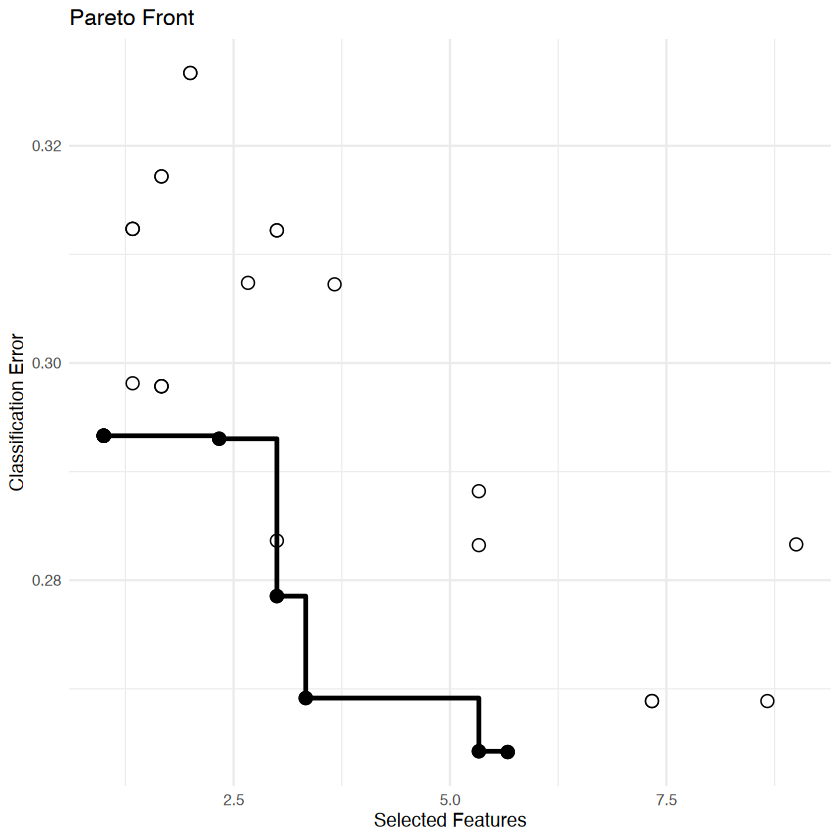

In [ ]:
# 确定数据集
df_best <- instance$archive$best()[
  , .(classif.ce, selected_features)
] %>%
  rename(
    classif.ce_best = classif.ce,
    selected_features_best = selected_features
  )

df_all <- as.data.table(instance$archive)[
  , .(classif.ce, selected_features)
]

# 绘制帕累托前沿图
ggplot(df_all, aes(x = selected_features, y = classif.ce)) +
  geom_point(
    # 需要注意只有部分type可以同时设置fill和color参数
    shape = 21,
    color = "black",
    fill = "white",
    size = 3
  ) +
  geom_point(
    data = df_best,
    aes(x = selected_features_best, y = classif.ce_best),
    color = "black",
    size = 3
  ) +
  geom_step(
    data = df_best,
    aes(x = selected_features_best, y = classif.ce_best),
    color = "black",
    size = 1
  ) +
  labs(
    title = "Pareto Front",
    x = "Selected Features",
    y = "Classification Error"
  ) +
  theme_minimal()

# Hyperband

In [81]:
library(mlr3hyperband)

learner <- lrn("classif.xgboost")
learner$param_set$set_values(
  # tags = "budget"表示为保真度参数
  nrounds           = to_tune(p_int(16, 128, tags = "budget")),
  eta               = to_tune(1e-4, 1, logscale = TRUE),
  max_depth         = to_tune(1, 20),
  colsample_bytree  = to_tune(1e-1, 1),
  colsample_bylevel = to_tune(1e-1, 1),
  lambda            = to_tune(1e-3, 1e3, logscale = TRUE),
  alpha             = to_tune(1e-3, 1e3, logscale = TRUE),
  subsample         = to_tune(1e-1, 1)
)

In [86]:
instance <- ti(
  task = tsk("sonar"),
  learner = learner,
  resampling = rsmp("holdout"),
  measures = msr("classif.ce"),
  terminator = trm("none")
)

tuner <- tnr("hyperband", eta = 2, repetitions = 1)

In [ ]:
hyperband_schedule(r_min = 16, r_max = 128, eta = 2) %>% print()

# bracket stage budget     n
#       <int> <int>  <num> <num>
#  1:       3     0     16     8
#  2:       3     1     32     4
#  3:       3     2     64     2
#  4:       3     3    128     1
#  5:       2     0     32     6
#  6:       2     1     64     3
#  7:       2     2    128     1
#  8:       1     0     64     4
#  9:       1     1    128     2
# 10:       0     0    128     4

    bracket stage budget     n
      <int> <int>  <num> <num>
 1:       3     0     16     8
 2:       3     1     32     4
 3:       3     2     64     2
 4:       3     3    128     1
 5:       2     0     32     6
 6:       2     1     64     3
 7:       2     2    128     1
 8:       1     0     64     4
 9:       1     1    128     2
10:       0     0    128     4


In [89]:
tuner$optimize(instance)

INFO  [18:45:00.799] [bbotk] Starting to optimize 8 parameter(s) with '<OptimizerBatchHyperband>' and '<TerminatorNone>'
INFO  [18:45:00.860] [bbotk] Evaluating 8 configuration(s)
INFO  [18:45:00.871] [mlr3] Running benchmark with 8 resampling iterations
INFO  [18:45:00.876] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.246] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.256] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.276] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.284] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.292] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.303] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.310] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.318] [mlr

Warning message in .__Codomain__maximization_to_minimization(self = self, private = private, :
"'maximization_to_minimization' is deprecated.
Use 'direction' instead.
See help("Deprecated")"


INFO  [18:45:03.370] [bbotk] Evaluating 10 configuration(s)
INFO  [18:45:03.379] [mlr3] Running benchmark with 10 resampling iterations
INFO  [18:45:03.382] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.403] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.415] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.432] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.443] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.454] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.467] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.476] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.492] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.503] [mlr3] Applying learner 'classif.

Warning message in .__Codomain__maximization_to_minimization(self = self, private = private, :
"'maximization_to_minimization' is deprecated.
Use 'direction' instead.
See help("Deprecated")"


INFO  [18:45:03.576] [bbotk] Evaluating 9 configuration(s)
INFO  [18:45:03.584] [mlr3] Running benchmark with 9 resampling iterations
INFO  [18:45:03.587] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.648] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.691] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.703] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.719] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.744] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.757] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.767] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.785] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.797] [mlr3] Finished benchmark
INFO  [18

Warning message in .__Codomain__maximization_to_minimization(self = self, private = private, :
"'maximization_to_minimization' is deprecated.
Use 'direction' instead.
See help("Deprecated")"


INFO  [18:45:03.852] [bbotk] Evaluating 8 configuration(s)
INFO  [18:45:03.859] [mlr3] Running benchmark with 8 resampling iterations
INFO  [18:45:03.864] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.881] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.898] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.925] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.946] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:03.989] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:04.011] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:04.067] [mlr3] Applying learner 'classif.xgboost' on task 'sonar' (iter 1/1)
INFO  [18:45:04.088] [mlr3] Finished benchmark
INFO  [18:45:04.126] [bbotk] Result of batch 4:
INFO  [18:45:04.128] [bbotk]       alpha colsample_

alpha,colsample_bylevel,colsample_bytree,eta,lambda,max_depth,nrounds,subsample,learner_param_vals,x_domain,classif.ce
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<list>,<list>,<dbl>
-5.167628,0.6405421,0.1635366,-1.645923,-4.130636,15,128,0.9499041,"1.000000e+00, 0.000000e+00, 5.698066e-03, 6.405421e-01, 1.635366e-01, 1.928345e-01, 1.607265e-02, 1.500000e+01, 1.280000e+02, 9.499041e-01","5.698066e-03, 6.405421e-01, 1.635366e-01, 1.928345e-01, 1.607265e-02, 1.500000e+01, 1.280000e+02, 9.499041e-01",0.173913


In [ ]:
instance$result[, .(classif.ce, nrounds)] %>% print()

# classif.ce nrounds
#         <num>   <num>
# 1:   0.173913     128

   classif.ce nrounds
        <num>   <num>
1:   0.173913     128


In [ ]:
as.data.table(instance$archive)[,
  .(bracket, stage, classif.ce, eta, max_depth, colsample_bytree)
] %>%
  head() %>%
  print()

# bracket stage classif.ce       eta max_depth colsample_bytree
#      <int> <num>      <num>     <num>     <int>            <num>
# 1:       3     0  0.2463768 -3.257259        20        0.2196399
# 2:       3     0  0.2608696 -0.940556        11        0.4150344
# 3:       3     0  0.5652174 -1.483983        10        0.9384264
# 4:       3     0  0.3333333 -2.801802         5        0.1300527
# 5:       3     0  0.1884058 -1.412724         8        0.2851753
# 6:       3     0  0.2173913 -7.155206        17        0.6703062

   bracket stage classif.ce       eta max_depth colsample_bytree
     <int> <num>      <num>     <num>     <int>            <num>
1:       3     0  0.2463768 -3.257259        20        0.2196399
2:       3     0  0.2608696 -0.940556        11        0.4150344
3:       3     0  0.5652174 -1.483983        10        0.9384264
4:       3     0  0.3333333 -2.801802         5        0.1300527
5:       3     0  0.1884058 -1.412724         8        0.2851753
6:       3     0  0.2173913 -7.155206        17        0.6703062


# 贝叶斯调优

In [95]:
library(bbotk)
sinus_1D <- function(xs) 2 * xs$x * sin(14 * xs$x)

domain <- ps(x = p_dbl(0, 1))
codomain <- ps(y = p_dbl(tags = "minimize"))
objective <- ObjectiveRFun$new(
  sinus_1D,
  domain = domain,
  codomain = codomain,
)

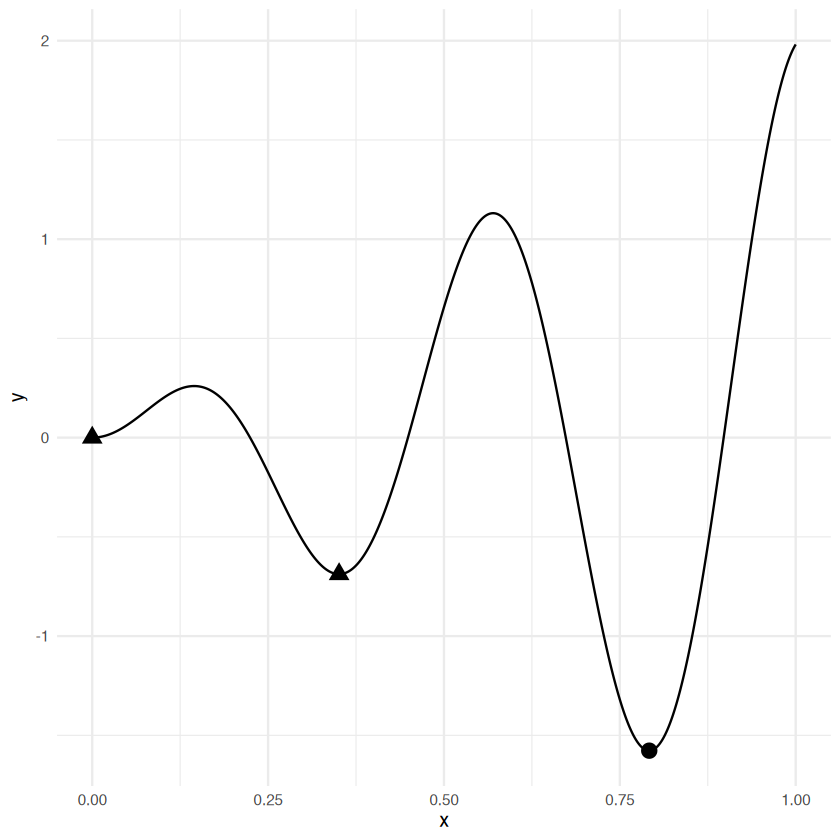

In [ ]:
library(ggplot2)

xydt <- generate_design_grid(domain, resolution = 1001)$data
xydt[, y := objective$eval_dt(xydt)$y]

optima <- data.table(x = c(0, 0.3509406, 0.7918238))
optima[, y := objective$eval_dt(optima)$y]
optima[, type := c("local", "local", "global")]

ggplot(xydt, aes(x = x, y = y)) +
  geom_line() +
  geom_point(
    data = optima,
    aes(x = x, y = y, shape = type),
    color = "black", size = 4
  ) +
  theme_minimal() +
  theme(legend.position = "none")

In [ ]:
xydt[y == min(y), ] %>% print()

# x         y
#    <num>     <num>
# 1: 0.792 -1.577239

       x         y
   <num>     <num>
1: 0.792 -1.577239


In [99]:
instance <- oi(
  objective,
  search_space = domain,
  terminator = trm("evals", n_evals = 20)
)
optimizer <- opt("random_search", batch_size = 20)
optimizer$optimize(instance)

INFO  [19:23:06.488] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=20, k=0]'
INFO  [19:23:06.500] [bbotk] Evaluating 20 configuration(s)
INFO  [19:23:06.559] [bbotk] Result of batch 1:
INFO  [19:23:06.563] [bbotk]           x           y
INFO  [19:23:06.563] [bbotk]  0.57103855  1.13081390
INFO  [19:23:06.563] [bbotk]  0.25958995 -0.24556018
INFO  [19:23:06.563] [bbotk]  0.07176869  0.12115046
INFO  [19:23:06.563] [bbotk]  0.34316349 -0.68343080
INFO  [19:23:06.563] [bbotk]  0.10980154  0.21947932
INFO  [19:23:06.563] [bbotk]  0.50288830  0.69089430
INFO  [19:23:06.563] [bbotk]  0.58337532  1.10996495
INFO  [19:23:06.563] [bbotk]  0.53084722  0.96850127
INFO  [19:23:06.563] [bbotk]  0.29124325 -0.46894913
INFO  [19:23:06.563] [bbotk]  0.45160345  0.03545348
INFO  [19:23:06.563] [bbotk]  0.39878957 -0.51389468
INFO  [19:23:06.563] [bbotk]  0.28218755 -0.40839318
INFO  [19:23:06.563] [bbotk]  0.30163659 -0.53243624
INFO  [

x,x_domain,y
<dbl>,<list>,<dbl>
0.8090892,0.8090892,-1.529985


In [100]:
optimal <- bb_optimize(
  objective,
  method = "random_search",
  max_evals = 20
)
optimal$instance$result

INFO  [19:23:57.559] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=20, k=0]'
INFO  [19:23:57.577] [bbotk] Evaluating 1 configuration(s)
INFO  [19:23:57.588] [bbotk] Result of batch 1:
INFO  [19:23:57.594] [bbotk]          x         y
INFO  [19:23:57.594] [bbotk]  0.2119455 0.0735341
INFO  [19:23:57.602] [bbotk] Evaluating 1 configuration(s)
INFO  [19:23:57.612] [bbotk] Result of batch 2:
INFO  [19:23:57.614] [bbotk]          x         y
INFO  [19:23:57.614] [bbotk]  0.4910106 0.5471437
INFO  [19:23:57.618] [bbotk] Evaluating 1 configuration(s)
INFO  [19:23:57.625] [bbotk] Result of batch 3:
INFO  [19:23:57.631] [bbotk]          x        y
INFO  [19:23:57.631] [bbotk]  0.5863194 1.099728
INFO  [19:23:57.637] [bbotk] Evaluating 1 configuration(s)
INFO  [19:23:57.643] [bbotk] Result of batch 4:
INFO  [19:23:57.644] [bbotk]          x       y
INFO  [19:23:57.644] [bbotk]  0.5609649 1.12193
INFO  [19:23:57.648] [bbotk] Evalua

x,x_domain,y
<dbl>,<list>,<dbl>
0.8178287,0.8178287,-1.469945


## 贝叶斯优化模块构建

In [ ]:
sample_domain <- ps(
  x = p_dbl(0, 1),
  y = p_dbl(0, 1)
)

generate_design_random(sample_domain, n = 3)$data %>% print()

# x         y
#         <num>     <num>
# 1: 0.95740527 0.1374738
# 2: 0.55460711 0.6097392
# 3: 0.06241586 0.4352701

            x         y
        <num>     <num>
1: 0.95740527 0.1374738
2: 0.55460711 0.6097392
3: 0.06241586 0.4352701


In [120]:
instance <- OptimInstanceBatchSingleCrit$new(
  objective,
  terminator = trm("evals", n_evals = 20)
)

In [ ]:
design <- data.table(x = c(0.1, 0.34, 0.65, 1))
instance$eval_batch(design)
instance$archive$data %>% print()

#        x          y  x_domain           timestamp batch_nr
#    <num>      <num>    <list>              <POSc>    <int>
# 1:  0.10  0.1970899 <list[1]> 2025-05-21 19:55:09        1
# 2:  0.34 -0.6792294 <list[1]> 2025-05-21 19:55:09        1
# 3:  0.65  0.4148279 <list[1]> 2025-05-21 19:55:09        1
# 4:  1.00  1.9812147 <list[1]> 2025-05-21 19:55:09        1

INFO  [19:55:09.724] [bbotk] Evaluating 4 configuration(s)
INFO  [19:55:09.754] [bbotk] Result of batch 1:
INFO  [19:55:09.756] [bbotk]     x          y
INFO  [19:55:09.756] [bbotk]  0.10  0.1970899
INFO  [19:55:09.756] [bbotk]  0.34 -0.6792294
INFO  [19:55:09.756] [bbotk]  0.65  0.4148279
INFO  [19:55:09.756] [bbotk]  1.00  1.9812147
       x          y  x_domain           timestamp batch_nr
   <num>      <num>    <list>              <POSc>    <int>
1:  0.10  0.1970899 <list[1]> 2025-05-21 19:55:09        1
2:  0.34 -0.6792294 <list[1]> 2025-05-21 19:55:09        1
3:  0.65  0.4148279 <list[1]> 2025-05-21 19:55:09        1
4:  1.00  1.9812147 <list[1]> 2025-05-21 19:55:09        1


In [114]:
lrn_gp <- lrn(
  "regr.km",
  covtype = "matern5_2",
  optim.method = "BFGS",
  control = list(trace = FALSE)
)

In [122]:
library(mlr3mbo)

surrogate <- srlrn(lrn_gp, archive = instance$archive)

In [ ]:
surrogate$update()
surrogate$learner$model

# Call:
# DiceKriging::km(design = data, response = truth, covtype = "matern5_2", 
#     optim.method = "BFGS", control = pv$control)

# Trend  coeff.:
#                Estimate
#  (Intercept)     0.7899

# Covar. type  : matern5_2 
# Covar. coeff.:
#                Estimate
#     theta(x)     0.3014

# Variance estimate: 1.069737


Call:
DiceKriging::km(design = data, response = truth, covtype = "matern5_2", 
    optim.method = "BFGS", control = pv$control)

Trend  coeff.:
               Estimate
 (Intercept)     0.7899

Covar. type  : matern5_2 
Covar. coeff.:
               Estimate
    theta(x)     0.3014

Variance estimate: 1.069737

In [ ]:
acq_function <- acqf("ei", surrogate = surrogate)
acq_function$update()
acq_function$y_best

# -0.679229430453482

[1] -0.6792294

In [ ]:
xydt <- generate_design_grid(domain, resolution = 1001)$data
# Evaluate our sinusoidal function
xydt[, y := objective$eval_dt(xydt)$y]
# Evaluate expected improvement
xydt[, ei := acq_function$eval_dt(xydt[, "x"])]
# Make predictions from our data
xydt[, c("mean", "se") := surrogate$predict(xydt[, "x"])]
xydt[1:3] %>% print()

# x            y           ei      mean        se
#    <num>        <num>        <num>     <num>     <num>
# 1: 0.000 0.000000e+00 4.641761e-05 0.5190694 0.3632388
# 2: 0.001 2.799909e-05 4.171138e-05 0.5166360 0.3597194
# 3: 0.002 1.119854e-04 3.737927e-05 0.5141874 0.3561922

       x            y           ei      mean        se
   <num>        <num>        <num>     <num>     <num>
1: 0.000 0.000000e+00 4.641761e-05 0.5190694 0.3632388
2: 0.001 2.799909e-05 4.171138e-05 0.5166360 0.3597194
3: 0.002 1.119854e-04 3.737927e-05 0.5141874 0.3561922


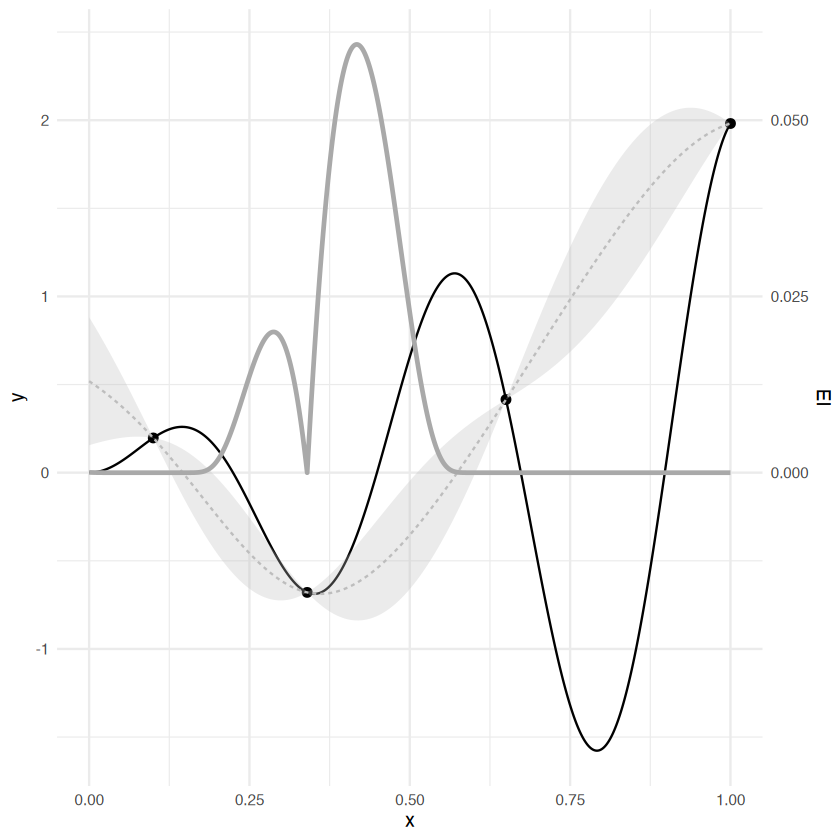

In [128]:
ggplot(xydt, mapping = aes(x = x, y = y)) +
  geom_point(size = 2, data = instance$archive$data) +
  geom_line() +
  geom_line(aes(y = mean), colour = "gray", linetype = 2) +
  geom_ribbon(
    aes(ymin = mean - se, ymax = mean + se),
    fill = "gray", alpha = 0.3
  ) +
  geom_line(aes(y = ei * 40), linewidth = 1, colour = "darkgray") +
  scale_y_continuous(
    "y",
    sec.axis = sec_axis(
      ~ . * 0.025,
      name = "EI",
      breaks = c(0, 0.025, 0.05)
    )
  ) +
  theme_minimal()

In [ ]:
acq_optimizer <- acqo(
  optimizer = opt("nloptr", algorithm = "NLOPT_GN_ORIG_DIRECT"),
  terminator = trm("stagnation", iters = 100, threshold = 1e-5),
  acq_function = acq_function
)

candidate <- acq_optimizer$optimize()
candidate %>% print()

# x     acq_ei  x_domain .already_evaluated
#       <num>      <num>    <list>             <lgcl>
# 1: 0.417289 0.06074387 <list[1]>              FALSE

          x     acq_ei  x_domain .already_evaluated
      <num>      <num>    <list>             <lgcl>
1: 0.417289 0.06074387 <list[1]>              FALSE


In [ ]:
as.data.table(mlr_loop_functions)[, .(key, label, instance)] %>% print()

# Key: <key>
#                key                         label    instance
#             <char>                        <char>      <char>
# 1:    bayesopt_ego Efficient Global Optimization single-crit
# 2:    bayesopt_emo           Multi-Objective EGO  multi-crit
# 3:   bayesopt_mpcl      Multipoint Constant Liar single-crit
# 4: bayesopt_parego                        ParEGO  multi-crit
# 5: bayesopt_smsego                       SMS-EGO  multi-crit

Key: <key>
               key                         label    instance
            <char>                        <char>      <char>
1:    bayesopt_ego Efficient Global Optimization single-crit
2:    bayesopt_emo           Multi-Objective EGO  multi-crit
3:   bayesopt_mpcl      Multipoint Constant Liar single-crit
4: bayesopt_parego                        ParEGO  multi-crit
5: bayesopt_smsego                       SMS-EGO  multi-crit


In [ ]:
my_simple_ego <- function(
  instance,
  surrogate,
  acq_function,
  acq_optimizer,
  init_design_size
) {
  # 设置各组件
  surrogate$archive <- instance$archive
  acq_function$surrogate <- surrogate
  acq_optimizer$acq_function <- acq_function

  search_space <- instance$search_space

  # 初始设计
  design <- generate_design_sobol(search_space, n = init_design_size)$data
  instance$eval_batch(design)

  # MBO循环
  repeat {
    candidate <- tryCatch({
      # 更新代理模型
      acq_function$surrogate$update()
      # 更新采集函数
      acq_function$update()
      # 优化采集函数，获得新候选点
      acq_optimizer$optimize()
    }, error = function(e) {
      generate_design_random(search_space, n = 1L)$data
    })

    # 评估候选点并加入archive
    tryCatch({
      instance$eval_batch(candidate)
    }, error = function(e) {
      # 如果已终止（如超时），$eval_batch()会抛出错误
    })

    if (instance$is_terminated) break
  }

  return(instance)
}


In [133]:
bayesopt_ego <- mlr_loop_functions$get("bayesopt_ego")
surrogate <- srlrn(
  lrn(
    "regr.km",
    covtype = "matern5_2",
    optim.method = "BFGS",
    control = list(trace = FALSE)
  )
)
acq_function <- acqf("ei")
acq_optimizer <- acqo(
  optimizer = opt("nloptr", algorithm = "NLOPT_GN_ORIG_DIRECT"),
  terminator = trm("stagnation", iters = 100, threshold = 1e-5),
  acq_function = acq_function
)

optimizer <- opt(
  "mbo",
  loop_function = bayesopt_ego,
  surrogate = surrogate,
  acq_function = acq_function,
  acq_optimizer = acq_optimizer
)

In [135]:
instance <- OptimInstanceBatchSingleCrit$new(
  objective,
  terminator = trm("evals", n_evals = 20)
)

In [136]:
design <- data.table(x = c(0.1, 0.34, 0.65, 1))
instance$eval_batch(design)
optimizer$optimize(instance)

INFO  [20:15:52.010] [bbotk] Evaluating 4 configuration(s)
INFO  [20:15:52.067] [bbotk] Result of batch 1:
INFO  [20:15:52.069] [bbotk]     x          y
INFO  [20:15:52.069] [bbotk]  0.10  0.1970899
INFO  [20:15:52.069] [bbotk]  0.34 -0.6792294
INFO  [20:15:52.069] [bbotk]  0.65  0.4148279
INFO  [20:15:52.069] [bbotk]  1.00  1.9812147
INFO  [20:15:52.122] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerMbo>' and '<TerminatorEvals> [n_evals=20, k=0]'
INFO  [20:15:53.443] [bbotk] Evaluating 1 configuration(s)
INFO  [20:15:53.448] [bbotk] Result of batch 2:
INFO  [20:15:53.449] [bbotk]         x     acq_ei  x_domain .already_evaluated          y
INFO  [20:15:53.449] [bbotk]  0.417289 0.06074388 <list[1]>              FALSE -0.3563394
INFO  [20:15:54.188] [bbotk] Evaluating 1 configuration(s)
INFO  [20:15:54.192] [bbotk] Result of batch 3:
INFO  [20:15:54.194] [bbotk]          x     acq_ei  x_domain .already_evaluated          y
INFO  [20:15:54.194] [bbotk]  0.2843317 0.0608510

x,x_domain,y
<dbl>,<list>,<dbl>
0.7921811,0.7921811,-1.577224


In [137]:
tuner <- tnr(
  "mbo",
  loop_function = bayesopt_ego,
  surrogate = surrogate,
  acq_function = acq_function,
  acq_optimizer = acq_optimizer
)

lrn_svm <- lrn(
  "classif.svm",
  kernel = "radial",
  type = "C-classification",
  cost  = to_tune(1e-5, 1e5, logscale = TRUE),
  gamma = to_tune(1e-5, 1e5, logscale = TRUE)
)

instance <- tune(
  tuner,
  tsk("sonar"),
  lrn_svm,
  rsmp("cv", folds = 3),
  msr("classif.ce"),
  25
)

instance$result

INFO  [20:22:32.282] [bbotk] Starting to optimize 2 parameter(s) with '<OptimizerMbo>' and '<TerminatorEvals> [n_evals=25, k=0]'
INFO  [20:22:32.318] [bbotk] Evaluating 8 configuration(s)
INFO  [20:22:32.329] [mlr3] Running benchmark with 24 resampling iterations
INFO  [20:22:32.333] [mlr3] Applying learner 'classif.svm' on task 'sonar' (iter 1/3)
INFO  [20:22:32.405] [mlr3] Applying learner 'classif.svm' on task 'sonar' (iter 2/3)
INFO  [20:22:32.418] [mlr3] Applying learner 'classif.svm' on task 'sonar' (iter 3/3)
INFO  [20:22:32.433] [mlr3] Applying learner 'classif.svm' on task 'sonar' (iter 1/3)
INFO  [20:22:32.446] [mlr3] Applying learner 'classif.svm' on task 'sonar' (iter 2/3)
INFO  [20:22:32.458] [mlr3] Applying learner 'classif.svm' on task 'sonar' (iter 3/3)
INFO  [20:22:32.470] [mlr3] Applying learner 'classif.svm' on task 'sonar' (iter 1/3)
INFO  [20:22:32.483] [mlr3] Applying learner 'classif.svm' on task 'sonar' (iter 2/3)
INFO  [20:22:32.496] [mlr3] Applying learner 'cl

cost,gamma,learner_param_vals,x_domain,classif.ce
<dbl>,<dbl>,<list>,<list>,<dbl>
11.51234,-4.8747,"radial , C-classification , 99941.5253819679 , 0.00763738480940117","9.994153e+04, 7.637385e-03",0.1202208


In [138]:
tuner <- tnr(
  "mbo",
  loop_function = bayesopt_parego,
  surrogate = surrogate,
  acq_function = acq_function,
  acq_optimizer = acq_optimizer
)

lrn_rpart <- lrn(
  "classif.rpart",
  cp = to_tune(1e-04, 1e-1),
  minsplit = to_tune(2, 64),
  maxdepth = to_tune(1, 30)
)

instance <- tune(
  tuner,
  tsk("sonar"),
  lrn_rpart,
  rsmp("cv", folds = 3),
  msrs(c("classif.tpr", "classif.fpr")),
  25
)

INFO  [20:24:26.895] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerMbo>' and '<TerminatorEvals> [n_evals=25, k=0]'
INFO  [20:24:26.897] [bbotk] Evaluating 12 configuration(s)
INFO  [20:24:26.902] [mlr3] Running benchmark with 36 resampling iterations
INFO  [20:24:26.906] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/3)
INFO  [20:24:26.919] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/3)
INFO  [20:24:26.930] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/3)
INFO  [20:24:26.940] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/3)
INFO  [20:24:26.952] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/3)
INFO  [20:24:26.962] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/3)
INFO  [20:24:26.972] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/3)
INFO  [20:24:26.983] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/3)
INFO  [20:24:26.992] [mlr3] App

In [ ]:
sinus_1D_noisy <- function(xs) {
  2 * xs$x * sin(14 * xs$x) + rnorm(1, mean = 0, sd = 0.1)
}

domain <- ps(x = p_dbl(lower = 0, upper = 1))
codomain <- ps(y = p_dbl(tags = "minimize"))

objective_noisy <- ObjectiveRFun$new(
  fun = sinus_1D_noisy,
  domain = domain,
  codomain = codomain,
  properties = "noisy"
)

In [139]:
srlrn(lrn("regr.km", nugget.estim = TRUE))

<SurrogateLearner>: LearnerRegrKM
* Parameters: assert_insample_perf=FALSE, catch_errors=TRUE,
  impute_method=random

In [ ]:
opt(
  "mbo",
  loop_function = bayesopt_ego,
  surrogate = surrogate,
  acq_function = acq_function,
  acq_optimizer = acq_optimizer,
  result_assigner = ras("surrogate")
)

# 练习

## 练习1

In [141]:
# 定义任务
tsk_mtcars <- tsk("mtcars")

# 定义学习器
# 调整mtry，sample.fraction 和 num.trees参数
lrn_rf <- lrn(
  "regr.ranger",
  mtry = to_tune(1, 10),
  sample.fraction = to_tune(0.1, 1),
  num.trees = to_tune(100, 1000)
)

# 定义重抽样策略
rsmp_cv3 <- rsmp("cv", folds = 3)

# 定义度量指标
msr_mse <- msr("regr.mse")

# 定义调优器
tnr_random <- tnr(
  "random_search"
)

# 定义终止器
trm_evals50 <- trm("evals", n_evals = 50)

# 定义调优实例
instance_random <- tune(
  task = tsk_mtcars,
  learner = lrn_rf,
  resampling = rsmp_cv3,
  measure = msr_mse,
  terminator = trm_evals50,
  tuner = tnr_random
)

INFO  [20:42:41.403] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=50, k=0]'
INFO  [20:42:41.416] [bbotk] Evaluating 1 configuration(s)
INFO  [20:42:41.420] [mlr3] Running benchmark with 3 resampling iterations
INFO  [20:42:41.423] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 1/3)
INFO  [20:42:41.437] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 2/3)
INFO  [20:42:41.476] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 3/3)
INFO  [20:42:41.490] [mlr3] Finished benchmark
INFO  [20:42:41.503] [bbotk] Result of batch 1:
INFO  [20:42:41.505] [bbotk]  mtry num.trees sample.fraction regr.mse warnings errors runtime_learners
INFO  [20:42:41.505] [bbotk]     9       434       0.5808099 12.04607        0      0            0.028
INFO  [20:42:41.505] [bbotk]                                 uhash
INFO  [20:42:41.505] [bbotk]  2dec7024-1271-4612-8166-ddf0a0f3bc41
INFO  [20:42:41.511] [bbotk

In [142]:
tuner_mbo <- tnr("mbo")

instance_mbo <- tune(
  task = tsk_mtcars,
  learner = lrn_rf,
  resampling = rsmp_cv3,
  measure = msr_mse,
  terminator = trm_evals50,
  tuner = tuner_mbo
)

INFO  [20:45:23.104] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerMbo>' and '<TerminatorEvals> [n_evals=50, k=0]'
INFO  [20:45:23.107] [bbotk] Evaluating 12 configuration(s)
INFO  [20:45:23.112] [mlr3] Running benchmark with 36 resampling iterations
INFO  [20:45:23.115] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 1/3)
INFO  [20:45:23.145] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 2/3)
INFO  [20:45:23.168] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 3/3)
INFO  [20:45:23.199] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 1/3)
INFO  [20:45:23.211] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 2/3)
INFO  [20:45:23.222] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 3/3)
INFO  [20:45:23.232] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 1/3)
INFO  [20:45:23.240] [mlr3] Applying learner 'regr.ranger' on task 'mtcars' (iter 2/3)
INFO  [20:45:23.247] [mlr3] Applying le

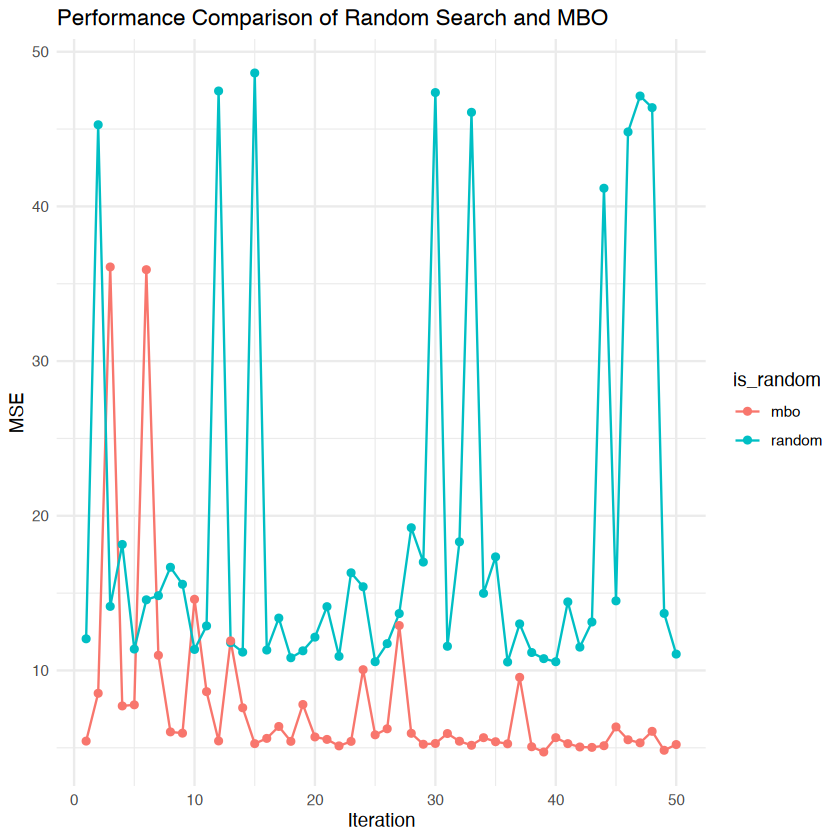

In [155]:
df_random <- as.data.table(instance_random$archive) %>%
  select(regr.mse) %>%
  mutate(
    row = row_number(),
    is_random = "random"
  )

df_mbo <- as.data.table(instance_mbo$archive) %>%
  select(regr.mse) %>%
  mutate(
    row = row_number(),
    is_random = "mbo"
  )

# 合并数据
df_combined <- df_random %>%
  bind_rows(df_mbo) %>%
  mutate(is_random = as.factor(is_random))

# 绘制性能比较图
ggplot(df_combined, aes(x = row)) +
  geom_line(aes(y = regr.mse, color = is_random)) +
  geom_point(aes(y = regr.mse, color = is_random)) +
  labs(
    title = "Performance Comparison of Random Search and MBO",
    x = "Iteration",
    y = "MSE"
  ) +
  theme_minimal()

In [ ]:
acqf()